# Chinese KG Implementation
#### https://www.analyticsvidhya.com/blog/2019/10/how-to-build-knowledge-graph-text-using-spacy/

In [ ]:
# import packages needed
from codecs import open as codecs_open
from opencc import OpenCC
from tqdm import tqdm
import json
import os
import monpa
import pandas as pd
import spacy

# Prepare data from raw json file

In [ ]:
# prepare raw data for knowledge graph

dir_path = "D:/Windows_Storage/r08546036/36/College/Research/Datasets/wiki_zh/"
dir_num_limit = 5 # limit of data using
count = 0
file_num = 0

id_list = []
url_list = []
title_list = []
text_list = []


for index, file_dir in enumerate(tqdm(os.listdir(dir_path))):
    count += 1
    sub_dir_path = dir_path + file_dir + "/"
    for file_index, file in enumerate(os.listdir(sub_dir_path)):
        # with open(file_path, "r", encoding="utf8") as file_to_be_read:
        file_to_be_read = codecs_open(sub_dir_path + file, 'r', encoding='utf8')
        lines = file_to_be_read.readlines()
        for line in lines:
            try:
                json_file = json.loads(line)
                id_list.append(json_file['id'])
                url_list.append(json_file['url'])
                title_list.append(json_file['title'])
                text_list.append(json_file['text'])
            except json.JSONDecodeError:
                pass
            
            
    # condition to break
#     if count >= dir_num_limit:
#         break

            
# create datframe with parsed data
df_text = pd.DataFrame({
        'id':id_list,
        'url':url_list,
        'title':title_list,
        'text':text_list
 })

print("Datafram length", len(df_text))

# translate data to traditional chinese

cc = OpenCC('s2twp')

for index, text in enumerate(tqdm(df_text.loc[:, 'text'])):
    df_text.loc[index, 'text_translated'] = cc.convert(text)


In [ ]:
df_text.to_csv("D:/Windows_Storage/r08546036/College/Research/Datasets/wiki2019.csv",
               encoding="utf8",
              index=None)

# Parsing data and Construct Knowledge Graph

In [1]:
from spacy.matcher import Matcher 
from spacy.tokens import Span 
from spacy import displacy
import bs4
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import re
import requests
import spacy
from tqdm import tqdm


# spacy chinese package information: https://spacy.io/models/zh
# https://github.com/explosion/spaCy/issues/4577

# !python -m spacy download en_core_web_sm
# !python -m spacy download zh_core_web_sm
# !python -m spacy download zh_core_web_md
import zh_core_web_md

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [2]:
# read in data
df_text = pd.read_csv("D:/Windows_Storage/r08546036/College/Research/Datasets/wiki2019.csv", encoding="utf8")

In [4]:
# execute data with nlp package
sentence = df_text.loc[0, 'text_translated']
nlp = zh_core_web_md.load()

doc = nlp(sentence)

# for tok in doc:
#     print(tok.text, "...", tok.dep_)

In [14]:
def get_entities(sent):
#     chunk 1
#     I have defined a few empty variables in this chunk. 
#     prv_tok_dep and prv_tok_text will hold the dependency tag of the previous word 
#     in the sentence and that previous word itself, respectively. 
#     prefix and modifier will hold the text that is associated with the subject or the object.
    ent1 = ""
    ent2 = ""

    prv_tok_dep = ""        # dependency tag of previous token in the sentence
    prv_tok_text = ""     # previous token in the sentence

    prefix = ""
    modifier = ""

    #############################################################
    
    for tok in nlp(sent):
#         chunk 2
#         Next, we will loop through the tokens in the sentence. 
#         We will first check if the token is a punctuation mark or not. 
#         If yes, then we will ignore it and move on to the next token. 
#         If the token is a part of a compound word (dependency tag = “compound”), 
#         we will keep it in the prefix variable. 
#         A compound word is a combination of multiple words linked to form a word 
#         with a new meaning (example – “Football Stadium”, “animal lover”).
#         As and when we come across a subject or an object in the sentence, 
#         we will add this prefix to it. 
#         We will do the same thing with the modifier words, such as “nice shirt”, “big house”, etc.

        # if token is a punctuation mark then move on to the next token
        if tok.dep_ != "punct":
            # check: token is a compound word or not
            if tok.dep_ == "compound":
                prefix = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    prefix = prv_tok_text + " "+ tok.text
            
            # check: token is a modifier or not
            if tok.dep_.endswith("mod") == True:
                modifier = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    modifier = prv_tok_text + " "+ tok.text
            
#             chunk 3
#             Here, if the token is the subject, 
#             then it will be captured as the first entity in the ent1 variable. 
#             Variables such as prefix, modifier, prv_tok_dep, and prv_tok_text will be reset.
            if tok.dep_.find("subj") == True:
                ent1 = modifier +" "+ prefix + " "+ tok.text
                prefix = ""
                modifier = ""
                prv_tok_dep = ""
                prv_tok_text = ""            

#             chunk4
#             Here, if the token is the object, then it will be captured as the second entity in the ent2 variable. 
#             Variables such as prefix, modifier, prv_tok_dep, and prv_tok_text will again be reset
            if tok.dep_.find("obj") == True:
                ent2 = modifier +" "+ prefix +" "+ tok.text
                
#             chunk 5
#             Once we have captured the subject and the object in the sentence, 
#             we will update the previous token and its dependency tag.  
            # update variables
            prv_tok_dep = tok.dep_
            prv_tok_text = tok.text
    #############################################################

    return [ent1.strip(), ent2.strip()]

In [15]:
# loop through data
count_limit = 0
entity_pairs = []

for i in tqdm(df_text.loc[:, 'text_translated']):
    entity_pairs.append(get_entities(i))
    
    # counter
    if count_limit >= 1000:
        break
        
    count_limit += 1

  0%|          | 1000/1043191 [07:59<138:54:16,  2.08it/s]


In [7]:
# function to get relation

def get_relation(sent):

    doc = nlp(sent)

    # Matcher class object 
    matcher = Matcher(nlp.vocab)

    #define the pattern 
    pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

    matcher.add("matching_1", None, pattern) 

    matches = matcher(doc)
    k = len(matches) - 1

    span = doc[matches[k][1]:matches[k][2]] 

    return(span.text)

In [16]:
relations = [get_relation(i) for i in tqdm(df_text.loc[0:count_limit, 'text_translated'])]

print(pd.Series(relations).value_counts()[:50])

100%|██████████| 1001/1001 [08:25<00:00,  1.98it/s]

有     114
標準     57
指      18
為      17
包括     13
分為     11
認為      9
：       9
如下      7
參見      7
看       7
表示      6
進行      6
稱為      6
成為      6
分       5
)       5
是       5
支援      5
命名      5
作為      4
列表      4
之一      4
具有      4
發現      4
出現      4
Z       3
使用      3
節日      3
形成      3
收錄      3
達       3
釋出      3
舉行      3
用來      3
資料      3
提出      3
找到      3
到       3
稱       3
增加      3
建立      3
視為      3
列出      3
見       3
表列      3
如       2
開始      2
學科      2
成立      2
dtype: int64


In [17]:
# knowledge graph build up

# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [18]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

C:\Users\richi\anaconda3\envs\torch\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 596 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\richi\anaconda3\envs\torch\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 596 missing from current font.
  font.set_text(s, 0, flags=flags)


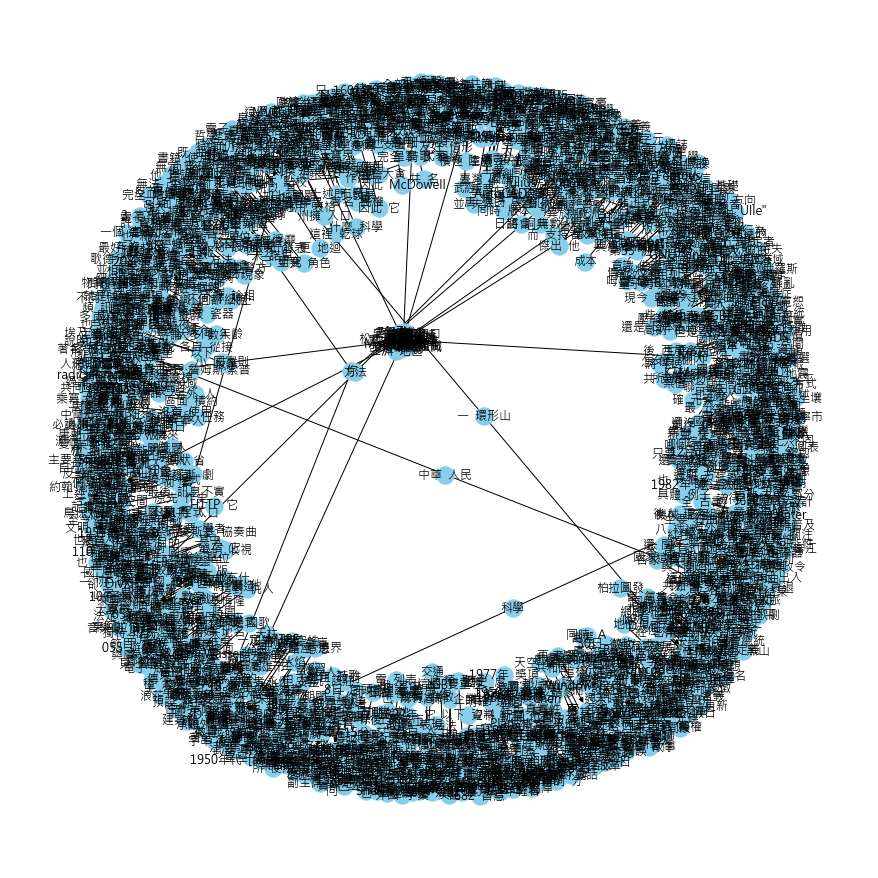

In [23]:
plt.figure(figsize=(12,12))
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

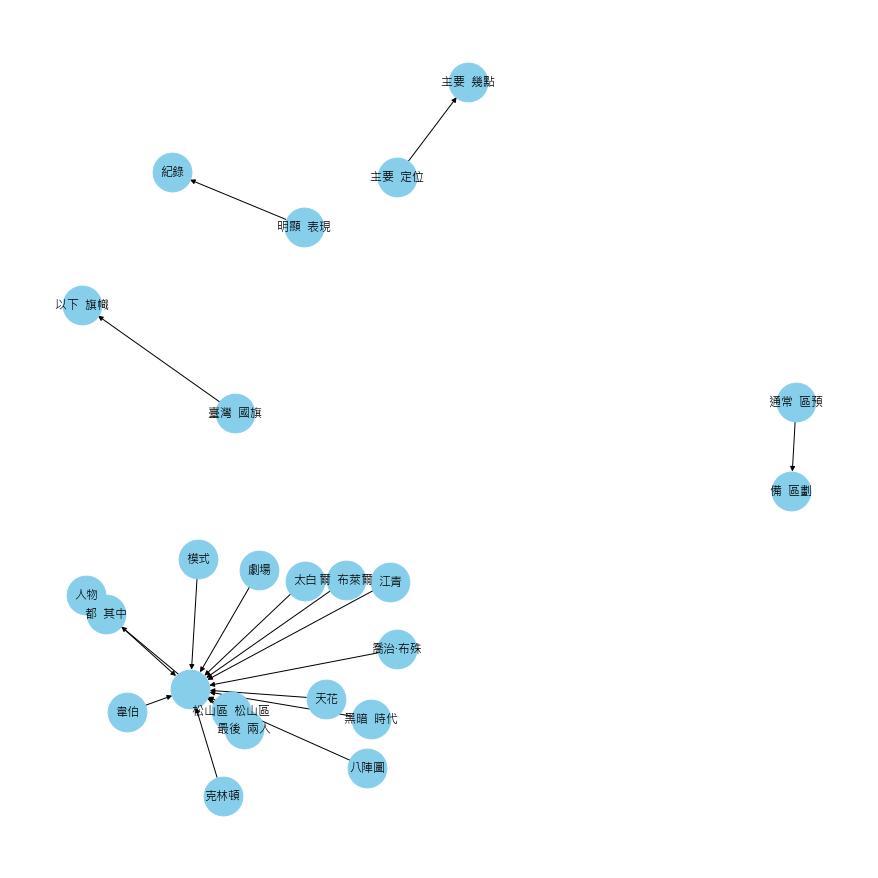

In [45]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="指"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()